In [1]:
import scanpy as sc
import anndata as ad
import os
import pickle
import pandas as pd
import numpy as np
import graphtools as gt
import phate
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import harmonypy as hm
from SCCAF import *
import diffxpy.api as de
import meld

np.random.seed(42)
font = {'size'   : 14}
mpl.rc('font', **font)

if os.path.isdir('/Users/mac/cloudstor/') == True:
    place = 'local'
    indir = '/Users/mac/cloudstor/sarah_projects/SCMDA231mets_chrcha/project_results/prefiltering/practice_all_data/'
    outdir = '/Users/mac/cloudstor/sarah_projects/SCMDA231mets_chrcha/project_results/sccaf/practice_all_data/'
    dataset = 'practice'
else:
    place = 'wolfpack'
    indir = '/share/ScratchGeneral/scoyou/sarah_projects/SCMDA231mets_chrcha/project_results/prefiltering/all_data/'
    outdir = '/share/ScratchGeneral/scoyou/sarah_projects/SCMDA231mets_chrcha/project_results/sccaf/all_data/'
    dataset = 'all'

print('Place: ', place,
       'indir: ', indir,
       'outdir: ', outdir)

sc.settings.autosave = True
sc.settings.figdir = outdir

Place:  local indir:  /Users/mac/cloudstor/sarah_projects/SCMDA231mets_chrcha/project_results/prefiltering/practice_all_data/ outdir:  /Users/mac/cloudstor/sarah_projects/SCMDA231mets_chrcha/project_results/sccaf/practice_all_data/


Make an ANNDATA object from matrix files exported from single experiment object

#### Load counts filtered for lowly expressed genes and low quality cells (2MAD each sample library size, gene counts, 2MAD whole experiment mito content).

Load ANNDATA object containing filtered counts, otherwise make one from csv and matrix files

In [2]:
if os.path.isfile(os.path.join(indir, 'Prefiltered_experiment_' + str(dataset) + '_filtered_counts_AnnData.h5ad')) == True:
    sdata = ad.read_h5ad(os.path.join(indir, 'Prefiltered_experiment_' + str(dataset) + '_filtered_counts_AnnData.h5ad'))
else:
    sdata = ad.read_mtx(os.path.join(indir, 'Prefiltered_experiment_' + str(dataset) + '_filtered_counts.mtx')).T
    pd_obs = pd.read_csv(os.path.join(indir, 'Prefiltered_experiment_' + str(dataset) + '_colData.csv'), index_col=0, header=0)
    cat_reps = pd_obs['Replicate'].astype(str)
    pd_obs.loc[:, ('Replicate')] = cat_reps
    pd_var = pd.read_csv(os.path.join(indir, 'Prefiltered_experiment_' + str(dataset) + '_rowData.csv'), index_col=0, header=0)
    sdata.obs = pd_obs
    sdata.var = pd_var
    sdata.write(os.path.join(indir, 'Prefiltered_experiment_' + str(dataset) + '_filtered_counts_AnnData.h5ad'))

sdata

AnnData object with n_obs × n_vars = 7055 × 12483
    obs: 'Sample', 'Barcode', 'old_Sample', 'Tissue', 'Replicate', 'cellIDs', 'Human_percent', 'Human_cells', 'Lib_size', 'Genes_detected', 'Mito_percent', 'Practice_subset', 'Mito_percent_discard', 'Genes_detected_discard', 'Libsize_discard', 'discard'
    var: 'ID', 'Symbol', 'Type', 'GeneSymbol', 'Organism', 'Ensembl', 'Liver_active', 'LN_active', 'Lung_active', 'Primary_active', 'Any_Active'

Normalise and log transform counts

In [3]:
sc.pp.normalize_total(sdata, target_sum=1e4)

In [4]:
sc.pp.log1p(sdata)

Identify variable genes (first within batch and then merged)

In [5]:
sc.pp.highly_variable_genes(sdata, n_top_genes=5000, batch_key='Replicate')

/Users/mac/local/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
/Users/mac/local/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/mac/local/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/mac/local/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Us

Save a copy of the whole dataset for differential expression testing

In [6]:
sdata.raw = sdata

Subset to HVG, regress out library size factors and scale the data (clipping to 10 SD above mean)

In [7]:
sdata = sdata[:, sdata.var.highly_variable]
sc.pp.regress_out(sdata, ['Lib_size'])
sc.pp.scale(sdata, max_value=10)

/Users/mac/local/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/mac/local/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


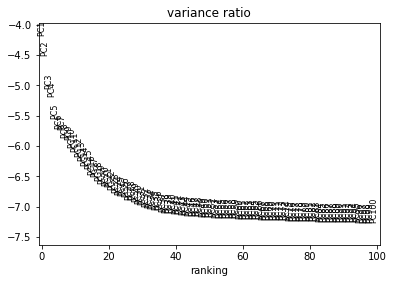

In [8]:
sc.tl.pca(sdata, svd_solver='arpack', n_comps=100, random_state=42)
sc.pl.pca_variance_ratio(sdata, log=True, n_pcs=100)

In [9]:
ho = hm.run_harmony(sdata.obsm['X_pca'], sdata.obs, 'Replicate', plot_convergence=True, max_iter_kmeans=100, random_state=42)
sdata.obsm["X_pca_harmony"] = np.transpose(ho.Z_corr)

2020-07-29 16:28:52,212 - harmonypy - INFO - Iteration 1 of 100
2020-07-29 16:28:59,257 - harmonypy - INFO - Iteration 2 of 100
2020-07-29 16:29:03,147 - harmonypy - INFO - Iteration 3 of 100
2020-07-29 16:29:07,714 - harmonypy - INFO - Iteration 4 of 100
2020-07-29 16:29:09,107 - harmonypy - INFO - Iteration 5 of 100
2020-07-29 16:29:10,273 - harmonypy - INFO - Iteration 6 of 100
2020-07-29 16:29:11,291 - harmonypy - INFO - Iteration 7 of 100
2020-07-29 16:29:12,243 - harmonypy - INFO - Converged after 7 iterations


In [10]:
#G = gt.Graph(np.array(sdata.obsm["X_pca"]), decay=40, knn=10, n_pca=None, n_jobs=-2, verbose=True, random_state=42)
#phate_op = phate.PHATE(knn_dist='precomputed', t='auto', gamma=1, n_jobs=-2, n_components=2, random_state=42, n_pca=None)
#data_phate = phate_op.fit_transform(G.kernel)
#sdata.obsm["X_phate_nobatch"] = data_phate[0:,0:]
#sc.pl.embedding(sdata, "X_phate_nobatch", color=['Replicate', 'Tissue'])

In [11]:
G = gt.Graph(np.array(sdata.obsm["X_pca_harmony"]), decay=40, knn=15, n_pca=None, n_jobs=-2, verbose=True, random_state=42)
phate_op = phate.PHATE(knn_dist='precomputed', t='auto', gamma=1, n_jobs=-2, n_components=2, random_state=42, n_pca=None)
data_phate = phate_op.fit_transform(G.kernel)
sdata.obsm["X_phate_harmony"] = data_phate[0:,0:]
sc.pl.embedding(sdata, "X_phate_harmony", color=['Replicate', 'Tissue'], save='.Cell_clustering_Harmony_batch_correction.png')

/Users/mac/local/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


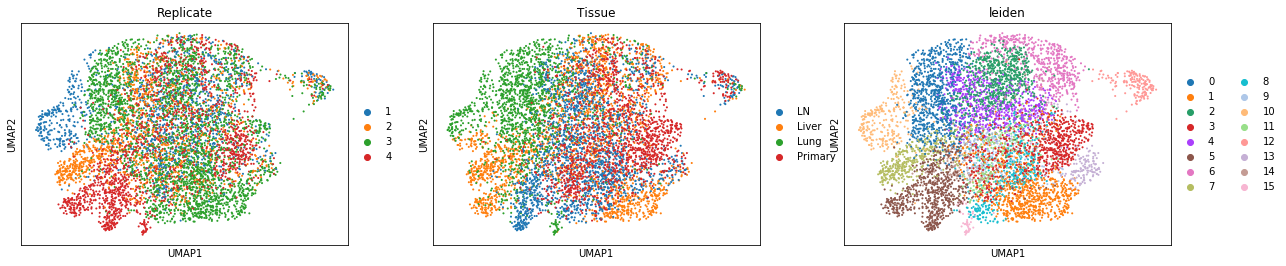

In [12]:
sc.pp.neighbors(sdata, n_neighbors=15, n_pcs=100, use_rep='X_pca', random_state=42)
sc.tl.leiden(sdata, random_state=42)
sc.tl.umap(sdata, random_state=42)
sc.pl.umap(sdata, color=['Replicate', 'Tissue', 'leiden'], save='.Cell_clustering_no_batch_correction.png')

/Users/mac/local/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


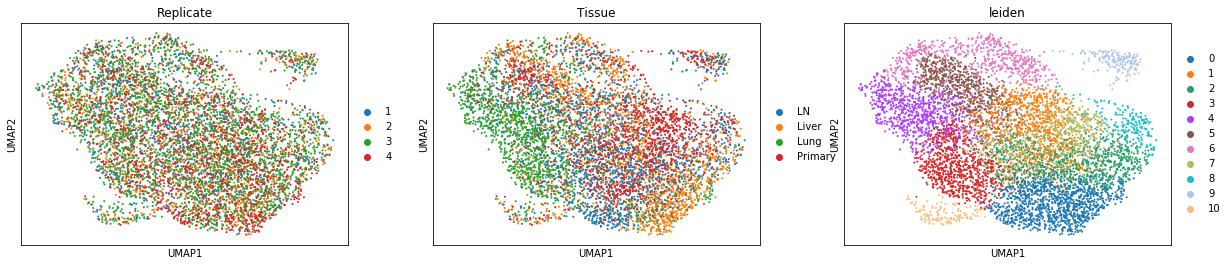

In [13]:
sc.pp.neighbors(sdata, n_neighbors=15, n_pcs=100, use_rep='X_pca_harmony', random_state=42)
sc.tl.leiden(sdata, random_state=42)
sc.tl.umap(sdata, random_state=42)
sc.pl.umap(sdata, color=['Replicate', 'Tissue', 'leiden'], save='.Cell_clustering_Harmony_batch_correction_preSCCAF.png')

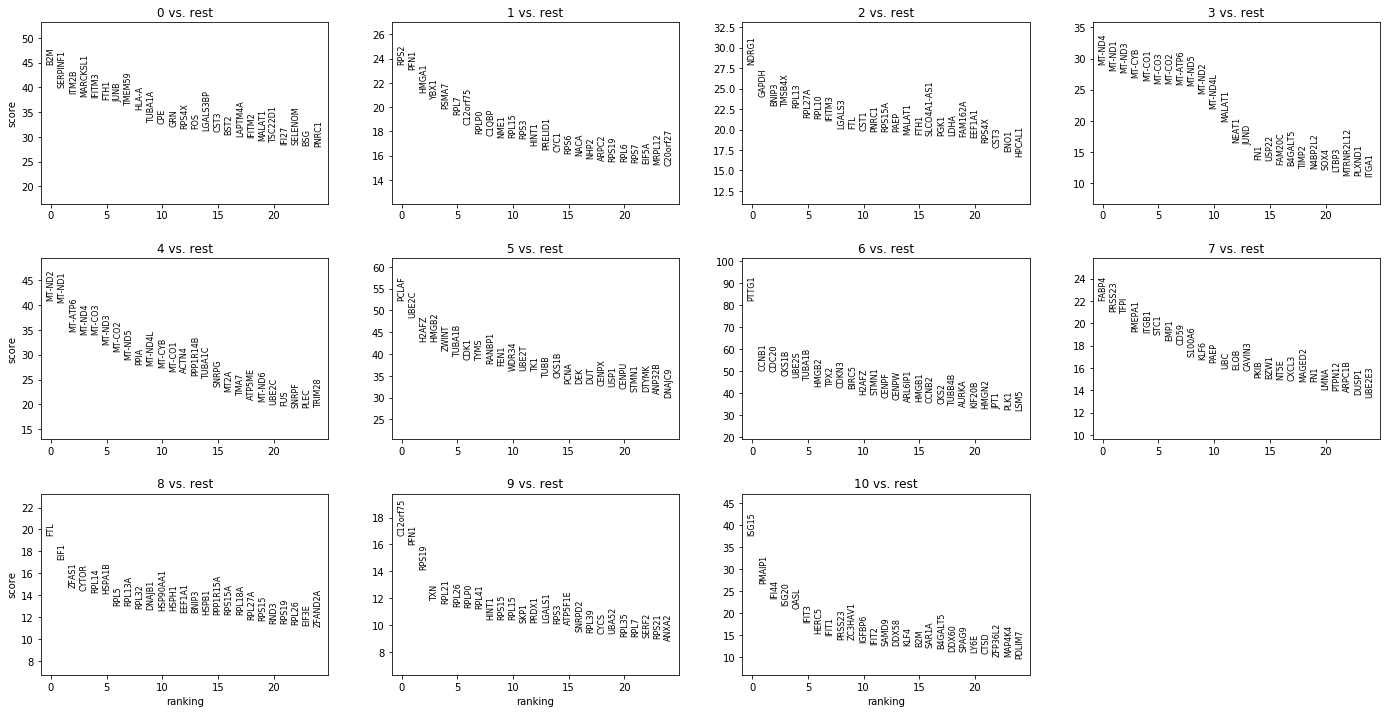

In [14]:
sc.tl.rank_genes_groups(sdata, 'leiden', method='t-test', rankby_abs=True)
sc.pl.rank_genes_groups(sdata, n_genes=25, sharey=False, save='.Top_markers_preSCCAF.png')

/Users/mac/local/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


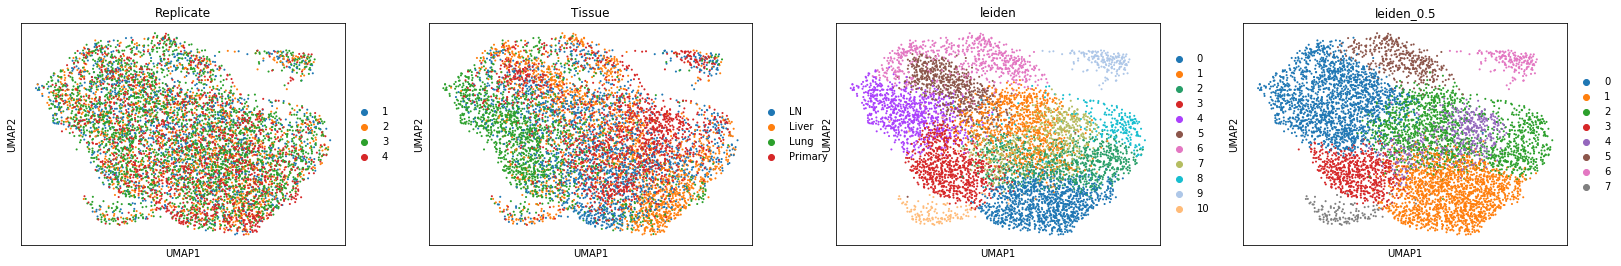

In [21]:
sdata.obs['L1_Round0'] = sdata.obs['leiden']
sc.tl.leiden(sdata, resolution=0.4, key_added='leiden_0.4', random_state=42)
sc.pl.umap(sdata, color=['Replicate', 'Tissue', 'leiden', 'leiden_0.4'], save='.Cell_clustering_Harmony_batch_correction_leiden_low_res.png')

/Users/mac/local/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


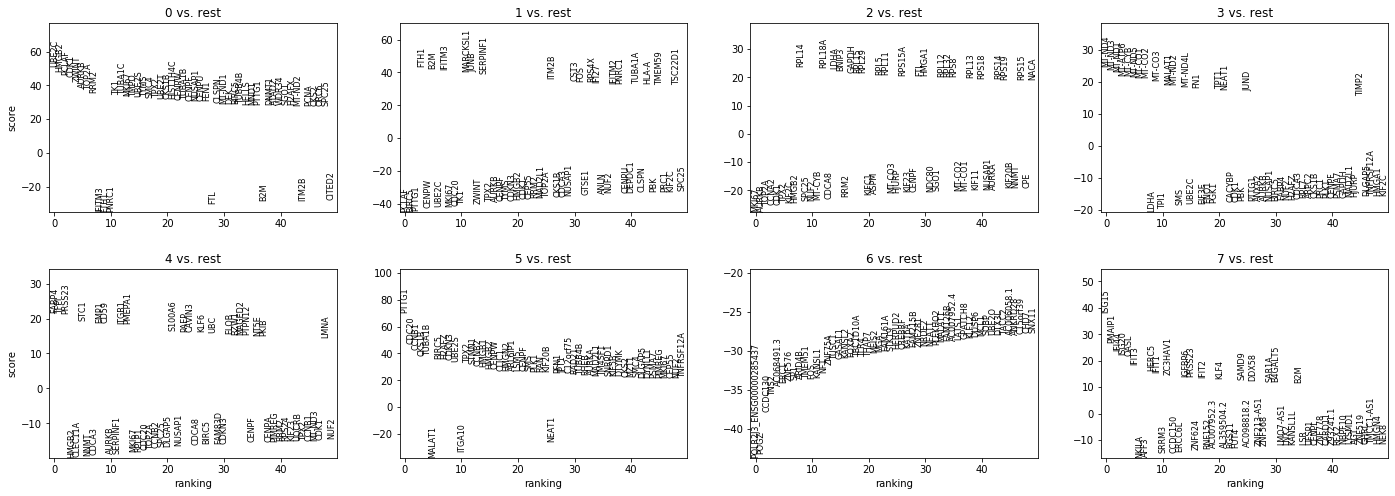

In [22]:
sc.tl.rank_genes_groups(sdata, 'leiden_0.4', method='logreg')
sc.pl.rank_genes_groups(sdata, n_genes=50, sharey=False, save='.Top_markers_leiden_low_res.png')

In [26]:
SCCAF_optimize_all(min_acc=0.9, ad=sdata, basis ='umap', start='L1_Round0', low_res='leiden_0.4', prefix='L1', plot=False)

R1norm_cutoff: 0.500000
R2norm_cutoff: 0.050000
Accuracy: 0.000000
Round1 ...
Mean CV accuracy: 0.7005
Accuracy on the training set: 0.9991
Accuracy on the hold-out set: 0.6753
Accuracy on the training set: 0.9962
Accuracy on the hold-out set: 0.6793
Accuracy on the training set: 0.9991
Accuracy on the hold-out set: 0.6653
Max R1mat: 0.534653
Max R2mat: 0.032469
min_acc: 0.665275
IGRAPH U-W- 11 2 --
+ attr: weight (e)
+ edges:
2--8 2--8
Round2 ...
Mean CV accuracy: 0.7109
Accuracy on the training set: 0.9990
Accuracy on the hold-out set: 0.6819
Accuracy on the training set: 1.0000
Accuracy on the hold-out set: 0.6783
Accuracy on the training set: 0.9990
Accuracy on the hold-out set: 0.6773
Max R1mat: 0.252280
Max R2mat: 0.032878
min_acc: 0.677340
IGRAPH U-W- 10 0 --
+ attr: weight (e)
Converge SCCAF_optimize no. cluster!
m1: 0.252280
m2: 0.032878
Accuracy: 0.677340
start_iter: 1
R1norm_cutoff: 0.242280
R2norm_cutoff: 0.031878
Accuracy: 0.677340
Round2 ...
Mean CV accuracy: 0.7316
Accur

/Users/mac/local/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'L1_Round0_self-projection' as categorical
... storing 'L1_result' as categorical
... storing 'L1_Round1' as categorical
... storing 'L1_Round1_self-projection' as categorical


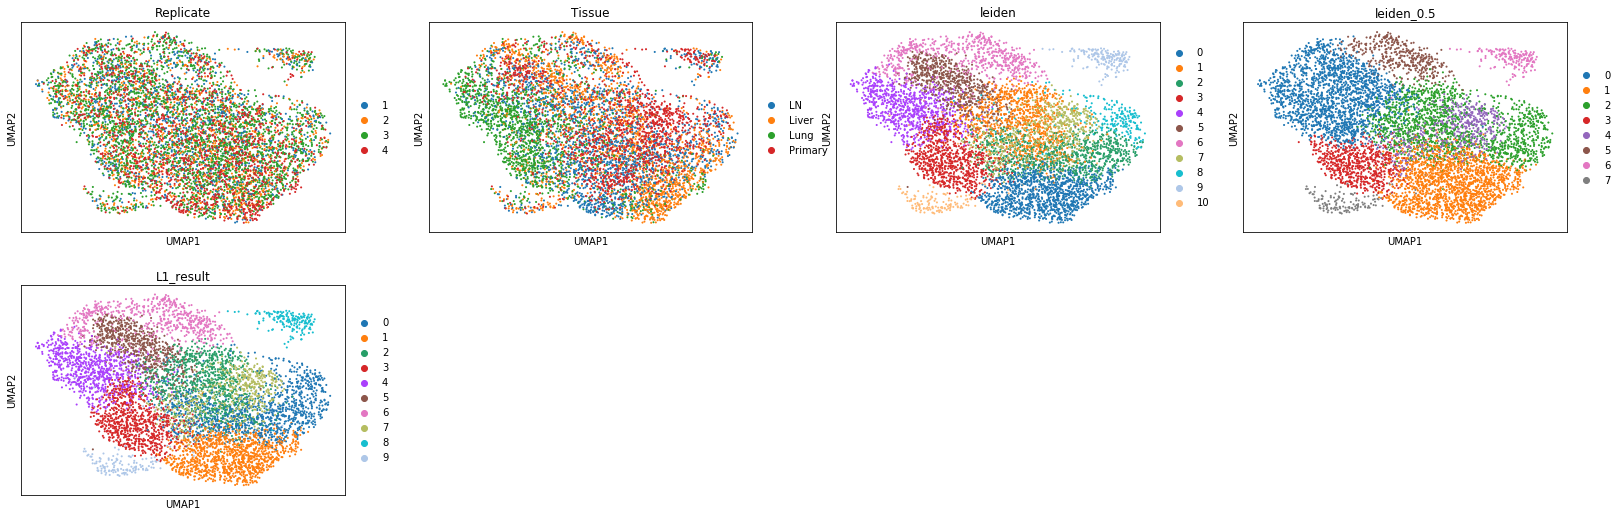

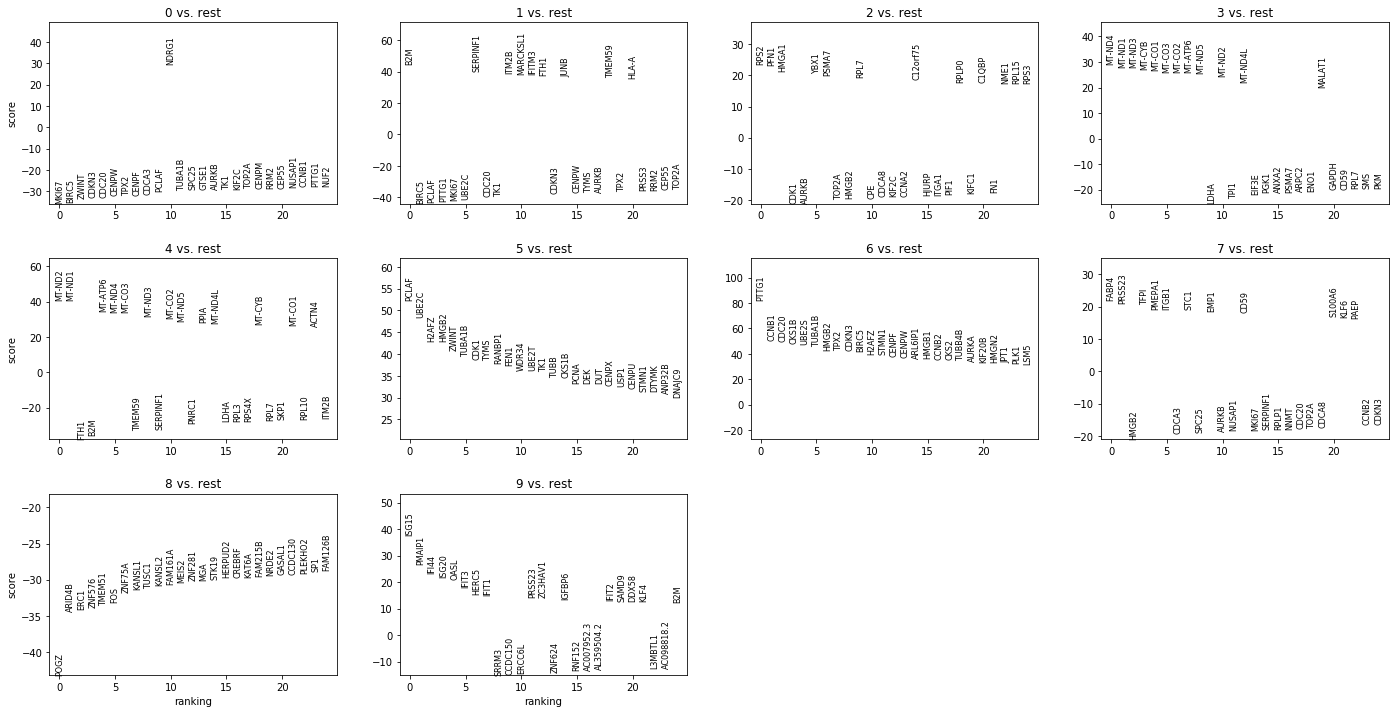

In [27]:
sc.pl.umap(sdata, color=['Replicate', 'Tissue', 'leiden', 'leiden_0.4', 'L1_result'], save='.Cell_clustering_Harmony_batch_correction_postSCCAF.png')
sc.tl.rank_genes_groups(sdata, 'L1_result', method='t-test', use_raw=True)
sc.pl.rank_genes_groups(sdata, n_genes=25, sharey=False, save='.Top_markers_postSCCAF.png')

In [ ]:
sc.pl.umap(sdata, color=['FABP4', 'PTTG1', 'FTH1', 'SERPINF1', 'HIF1A'])

Calculating KNN search...
Calculated KNN search in 1.37 seconds.
Calculating affinities...
Calculated affinities in 0.64 seconds.
Calculating PHATE...
  Running PHATE on precomputed affinity matrix with 7055 cells.
  Calculating graph and diffusion operator...
  Calculated graph and diffusion operator in 0.08 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.23 seconds.
    Calculating KMeans...
    Calculated KMeans in 28.92 seconds.
  Calculated landmark operator in 31.66 seconds.
  Calculating optimal t...
  Calculated optimal t in 2.74 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.81 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 10.45 seconds.
Calculated PHATE in 45.75 seconds.


/Users/mac/local/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


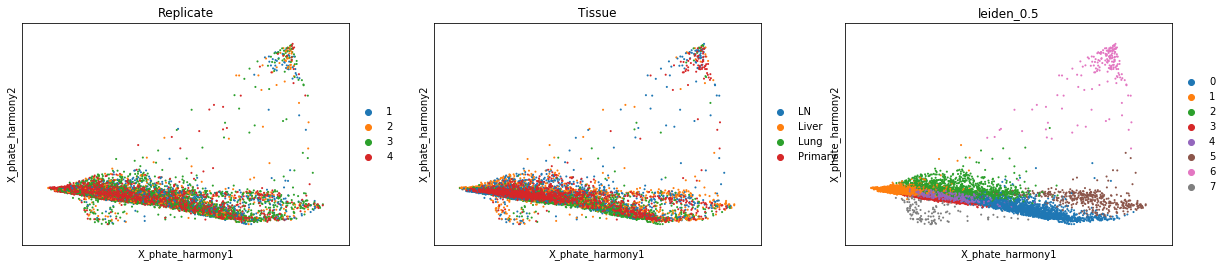

In [30]:
G = gt.Graph(np.array(sdata.obsm["X_pca_harmony"]), decay=40, knn=15, n_pca=None, n_jobs=-2, verbose=True, random_state=42)
phate_op = phate.PHATE(knn_dist='precomputed', t='auto', gamma=1, n_jobs=-2, n_components=2, random_state=42, n_pca=None)
data_phate = phate_op.fit_transform(G.kernel)
sdata.obsm["X_phate_harmony"] = data_phate[0:,0:]
sc.pl.embedding(sdata, "X_phate_harmony", color=['Replicate', 'Tissue', 'leiden_0.5'], save='.Cell_clustering_Harmony_batch_correction_phate.png')

In [ ]:
sdata.obs['leiden_Final'] = sdata.obs['leiden_0.5']
test_regressed_sf = de.test.wald(
    data=sdata,
    formula_loc="~ 1 + leiden_Final + Lib_size",
    factor_loc_totest="leiden_Final",
    as_numeric=["Lib_size"]
)

/Users/mac/local/miniconda3/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in log
  return func(*(_execute_task(a, cache) for a in args))


training location model: True
training scale model: True
iter   0: ll=nan


/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:288: RuntimeWarning: invalid value encountered in less
  ).squeeze().compute() < 1 / sys.float_info.epsilon)[0]


caught 3464 linalg singular matrix errors


/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:144: RuntimeWarning: invalid value encountered in greater
  idx_bad_step = idx_update[np.where(ll_proposal > ll_current[idx_update])[0]]
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:179: RuntimeWarning: invalid value encountered in less
  ll_previous < ll_current,  # loss gets worse
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:183: RuntimeWarning: invalid value encountered in less
  ) < pkg_constants.LLTOL_BY_FEATURE,


iter   1: ll=nan, converged: 0.00% (loc: 30.70%, scale update: False), in 5.94sec


/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:288: RuntimeWarning: invalid value encountered in less
  ).squeeze().compute() < 1 / sys.float_info.epsilon)[0]


caught 3464 linalg singular matrix errors


/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:144: RuntimeWarning: invalid value encountered in greater
  idx_bad_step = idx_update[np.where(ll_proposal > ll_current[idx_update])[0]]
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:179: RuntimeWarning: invalid value encountered in less
  ll_previous < ll_current,  # loss gets worse
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:183: RuntimeWarning: invalid value encountered in less
  ) < pkg_constants.LLTOL_BY_FEATURE,


iter   2: ll=nan, converged: 0.00% (loc: 30.72%, scale update: False), in 2.93sec


/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:288: RuntimeWarning: invalid value encountered in less
  ).squeeze().compute() < 1 / sys.float_info.epsilon)[0]


caught 3464 linalg singular matrix errors


/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:144: RuntimeWarning: invalid value encountered in greater
  idx_bad_step = idx_update[np.where(ll_proposal > ll_current[idx_update])[0]]
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:179: RuntimeWarning: invalid value encountered in less
  ll_previous < ll_current,  # loss gets worse
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:183: RuntimeWarning: invalid value encountered in less
  ) < pkg_constants.LLTOL_BY_FEATURE,


iter   3: ll=nan, converged: 0.00% (loc: 30.72%, scale update: False), in 2.81sec


/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:288: RuntimeWarning: invalid value encountered in less
  ).squeeze().compute() < 1 / sys.float_info.epsilon)[0]


caught 3464 linalg singular matrix errors


/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:144: RuntimeWarning: invalid value encountered in greater
  idx_bad_step = idx_update[np.where(ll_proposal > ll_current[idx_update])[0]]
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:179: RuntimeWarning: invalid value encountered in less
  ll_previous < ll_current,  # loss gets worse
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:183: RuntimeWarning: invalid value encountered in less
  ) < pkg_constants.LLTOL_BY_FEATURE,


iter   4: ll=nan, converged: 0.00% (loc: 30.72%, scale update: False), in 2.82sec


/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:288: RuntimeWarning: invalid value encountered in less
  ).squeeze().compute() < 1 / sys.float_info.epsilon)[0]


caught 3464 linalg singular matrix errors
iter   5: ll=nan, converged: 0.00% (loc: 30.72%, scale update: False), in 2.81sec
Fitting 5000 dispersion models: (progress not available with multiprocessing)

/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:144: RuntimeWarning: invalid value encountered in greater
  idx_bad_step = idx_update[np.where(ll_proposal > ll_current[idx_update])[0]]
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:179: RuntimeWarning: invalid value encountered in less
  ll_previous < ll_current,  # loss gets worse
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:183: RuntimeWarning: invalid value encountered in less
  ) < pkg_constants.LLTOL_BY_FEATURE,


/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:118: RuntimeWarning: invalid value encountered in greater
  idx_bad_step = idx_update[np.where(ll_proposal > ll_current[idx_update])[0]]
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:167: RuntimeWarning: invalid value encountered in less
  ll_last_b_update < ll_current,  # loss gets worse
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:171: RuntimeWarning: invalid value encountered in less
  ) < pkg_constants.LLTOL_BY_FEATURE,


iter   6: ll=nan, converged: 3.28% (loc: 3.28%, scale update: True), in 52.74sec


/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:288: RuntimeWarning: invalid value encountered in less
  ).squeeze().compute() < 1 / sys.float_info.epsilon)[0]


caught 3465 linalg singular matrix errors


/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:144: RuntimeWarning: invalid value encountered in greater
  idx_bad_step = idx_update[np.where(ll_proposal > ll_current[idx_update])[0]]
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:179: RuntimeWarning: invalid value encountered in less
  ll_previous < ll_current,  # loss gets worse
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:183: RuntimeWarning: invalid value encountered in less
  ) < pkg_constants.LLTOL_BY_FEATURE,


iter   7: ll=nan, converged: 3.28% (loc: 30.54%, scale update: False), in 5.67sec


/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:288: RuntimeWarning: invalid value encountered in less
  ).squeeze().compute() < 1 / sys.float_info.epsilon)[0]


caught 3464 linalg singular matrix errors


/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:144: RuntimeWarning: invalid value encountered in greater
  idx_bad_step = idx_update[np.where(ll_proposal > ll_current[idx_update])[0]]
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:179: RuntimeWarning: invalid value encountered in less
  ll_previous < ll_current,  # loss gets worse
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:183: RuntimeWarning: invalid value encountered in less
  ) < pkg_constants.LLTOL_BY_FEATURE,


iter   8: ll=nan, converged: 3.28% (loc: 30.60%, scale update: False), in 3.33sec


/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:288: RuntimeWarning: invalid value encountered in less
  ).squeeze().compute() < 1 / sys.float_info.epsilon)[0]


caught 3464 linalg singular matrix errors


/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:144: RuntimeWarning: invalid value encountered in greater
  idx_bad_step = idx_update[np.where(ll_proposal > ll_current[idx_update])[0]]
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:179: RuntimeWarning: invalid value encountered in less
  ll_previous < ll_current,  # loss gets worse
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:183: RuntimeWarning: invalid value encountered in less
  ) < pkg_constants.LLTOL_BY_FEATURE,


iter   9: ll=nan, converged: 3.28% (loc: 30.60%, scale update: False), in 3.17sec


/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:288: RuntimeWarning: invalid value encountered in less
  ).squeeze().compute() < 1 / sys.float_info.epsilon)[0]


caught 3464 linalg singular matrix errors


/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:144: RuntimeWarning: invalid value encountered in greater
  idx_bad_step = idx_update[np.where(ll_proposal > ll_current[idx_update])[0]]
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:179: RuntimeWarning: invalid value encountered in less
  ll_previous < ll_current,  # loss gets worse
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:183: RuntimeWarning: invalid value encountered in less
  ) < pkg_constants.LLTOL_BY_FEATURE,


iter  10: ll=nan, converged: 3.28% (loc: 30.60%, scale update: False), in 3.24sec


/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:288: RuntimeWarning: invalid value encountered in less
  ).squeeze().compute() < 1 / sys.float_info.epsilon)[0]


caught 3464 linalg singular matrix errors
iter  11: ll=nan, converged: 3.28% (loc: 30.60%, scale update: False), in 3.00sec
Fitting 4836 dispersion models: (progress not available with multiprocessing)

/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:144: RuntimeWarning: invalid value encountered in greater
  idx_bad_step = idx_update[np.where(ll_proposal > ll_current[idx_update])[0]]
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:179: RuntimeWarning: invalid value encountered in less
  ll_previous < ll_current,  # loss gets worse
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:183: RuntimeWarning: invalid value encountered in less
  ) < pkg_constants.LLTOL_BY_FEATURE,


/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:118: RuntimeWarning: invalid value encountered in greater
  idx_bad_step = idx_update[np.where(ll_proposal > ll_current[idx_update])[0]]
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:167: RuntimeWarning: invalid value encountered in less
  ll_last_b_update < ll_current,  # loss gets worse
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:171: RuntimeWarning: invalid value encountered in less
  ) < pkg_constants.LLTOL_BY_FEATURE,


iter  12: ll=nan, converged: 29.78% (loc: 29.78%, scale update: True), in 52.66sec


/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:288: RuntimeWarning: invalid value encountered in less
  ).squeeze().compute() < 1 / sys.float_info.epsilon)[0]


caught 3464 linalg singular matrix errors


/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:144: RuntimeWarning: invalid value encountered in greater
  idx_bad_step = idx_update[np.where(ll_proposal > ll_current[idx_update])[0]]
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:179: RuntimeWarning: invalid value encountered in less
  ll_previous < ll_current,  # loss gets worse
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:183: RuntimeWarning: invalid value encountered in less
  ) < pkg_constants.LLTOL_BY_FEATURE,


iter  13: ll=nan, converged: 29.78% (loc: 30.58%, scale update: False), in 4.13sec


/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:288: RuntimeWarning: invalid value encountered in less
  ).squeeze().compute() < 1 / sys.float_info.epsilon)[0]


caught 3464 linalg singular matrix errors


/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:144: RuntimeWarning: invalid value encountered in greater
  idx_bad_step = idx_update[np.where(ll_proposal > ll_current[idx_update])[0]]
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:179: RuntimeWarning: invalid value encountered in less
  ll_previous < ll_current,  # loss gets worse
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:183: RuntimeWarning: invalid value encountered in less
  ) < pkg_constants.LLTOL_BY_FEATURE,


iter  14: ll=nan, converged: 29.78% (loc: 30.58%, scale update: False), in 3.32sec


/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:288: RuntimeWarning: invalid value encountered in less
  ).squeeze().compute() < 1 / sys.float_info.epsilon)[0]


caught 3464 linalg singular matrix errors


/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:144: RuntimeWarning: invalid value encountered in greater
  idx_bad_step = idx_update[np.where(ll_proposal > ll_current[idx_update])[0]]
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:179: RuntimeWarning: invalid value encountered in less
  ll_previous < ll_current,  # loss gets worse
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:183: RuntimeWarning: invalid value encountered in less
  ) < pkg_constants.LLTOL_BY_FEATURE,


iter  15: ll=nan, converged: 29.78% (loc: 30.58%, scale update: False), in 3.48sec


/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:288: RuntimeWarning: invalid value encountered in less
  ).squeeze().compute() < 1 / sys.float_info.epsilon)[0]


caught 3464 linalg singular matrix errors


/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:144: RuntimeWarning: invalid value encountered in greater
  idx_bad_step = idx_update[np.where(ll_proposal > ll_current[idx_update])[0]]
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:179: RuntimeWarning: invalid value encountered in less
  ll_previous < ll_current,  # loss gets worse
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:183: RuntimeWarning: invalid value encountered in less
  ) < pkg_constants.LLTOL_BY_FEATURE,


iter  16: ll=nan, converged: 29.78% (loc: 30.58%, scale update: False), in 3.59sec


/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:288: RuntimeWarning: invalid value encountered in less
  ).squeeze().compute() < 1 / sys.float_info.epsilon)[0]


caught 3464 linalg singular matrix errors
iter  17: ll=nan, converged: 29.78% (loc: 30.58%, scale update: False), in 3.65sec
Fitting 3511 dispersion models: (progress not available with multiprocessing)

/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:144: RuntimeWarning: invalid value encountered in greater
  idx_bad_step = idx_update[np.where(ll_proposal > ll_current[idx_update])[0]]
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:179: RuntimeWarning: invalid value encountered in less
  ll_previous < ll_current,  # loss gets worse
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:183: RuntimeWarning: invalid value encountered in less
  ) < pkg_constants.LLTOL_BY_FEATURE,


/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:118: RuntimeWarning: invalid value encountered in greater
  idx_bad_step = idx_update[np.where(ll_proposal > ll_current[idx_update])[0]]
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:167: RuntimeWarning: invalid value encountered in less
  ll_last_b_update < ll_current,  # loss gets worse
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:171: RuntimeWarning: invalid value encountered in less
  ) < pkg_constants.LLTOL_BY_FEATURE,


iter  18: ll=nan, converged: 30.50% (loc: 30.50%, scale update: True), in 40.74sec


/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:288: RuntimeWarning: invalid value encountered in less
  ).squeeze().compute() < 1 / sys.float_info.epsilon)[0]


caught 3464 linalg singular matrix errors


/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:144: RuntimeWarning: invalid value encountered in greater
  idx_bad_step = idx_update[np.where(ll_proposal > ll_current[idx_update])[0]]
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:179: RuntimeWarning: invalid value encountered in less
  ll_previous < ll_current,  # loss gets worse
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:183: RuntimeWarning: invalid value encountered in less
  ) < pkg_constants.LLTOL_BY_FEATURE,


iter  19: ll=nan, converged: 30.50% (loc: 30.58%, scale update: False), in 3.51sec


/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:288: RuntimeWarning: invalid value encountered in less
  ).squeeze().compute() < 1 / sys.float_info.epsilon)[0]


caught 3464 linalg singular matrix errors


/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:144: RuntimeWarning: invalid value encountered in greater
  idx_bad_step = idx_update[np.where(ll_proposal > ll_current[idx_update])[0]]
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:179: RuntimeWarning: invalid value encountered in less
  ll_previous < ll_current,  # loss gets worse
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:183: RuntimeWarning: invalid value encountered in less
  ) < pkg_constants.LLTOL_BY_FEATURE,


iter  20: ll=nan, converged: 30.50% (loc: 30.58%, scale update: False), in 3.94sec


/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:288: RuntimeWarning: invalid value encountered in less
  ).squeeze().compute() < 1 / sys.float_info.epsilon)[0]


caught 3464 linalg singular matrix errors


/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:144: RuntimeWarning: invalid value encountered in greater
  idx_bad_step = idx_update[np.where(ll_proposal > ll_current[idx_update])[0]]
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:179: RuntimeWarning: invalid value encountered in less
  ll_previous < ll_current,  # loss gets worse
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:183: RuntimeWarning: invalid value encountered in less
  ) < pkg_constants.LLTOL_BY_FEATURE,


iter  21: ll=nan, converged: 30.50% (loc: 30.58%, scale update: False), in 3.73sec


/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:288: RuntimeWarning: invalid value encountered in less
  ).squeeze().compute() < 1 / sys.float_info.epsilon)[0]


caught 3464 linalg singular matrix errors


/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:144: RuntimeWarning: invalid value encountered in greater
  idx_bad_step = idx_update[np.where(ll_proposal > ll_current[idx_update])[0]]
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:179: RuntimeWarning: invalid value encountered in less
  ll_previous < ll_current,  # loss gets worse
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:183: RuntimeWarning: invalid value encountered in less
  ) < pkg_constants.LLTOL_BY_FEATURE,


iter  22: ll=nan, converged: 30.50% (loc: 30.58%, scale update: False), in 3.98sec


/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:288: RuntimeWarning: invalid value encountered in less
  ).squeeze().compute() < 1 / sys.float_info.epsilon)[0]


caught 3464 linalg singular matrix errors
iter  23: ll=nan, converged: 30.50% (loc: 30.58%, scale update: False), in 3.96sec
Fitting 3475 dispersion models: (progress not available with multiprocessing)

/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:144: RuntimeWarning: invalid value encountered in greater
  idx_bad_step = idx_update[np.where(ll_proposal > ll_current[idx_update])[0]]
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:179: RuntimeWarning: invalid value encountered in less
  ll_previous < ll_current,  # loss gets worse
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:183: RuntimeWarning: invalid value encountered in less
  ) < pkg_constants.LLTOL_BY_FEATURE,


/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:118: RuntimeWarning: invalid value encountered in greater
  idx_bad_step = idx_update[np.where(ll_proposal > ll_current[idx_update])[0]]
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:167: RuntimeWarning: invalid value encountered in less
  ll_last_b_update < ll_current,  # loss gets worse
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:171: RuntimeWarning: invalid value encountered in less
  ) < pkg_constants.LLTOL_BY_FEATURE,


iter  24: ll=nan, converged: 30.58% (loc: 30.58%, scale update: True), in 42.66sec


/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:288: RuntimeWarning: invalid value encountered in less
  ).squeeze().compute() < 1 / sys.float_info.epsilon)[0]


caught 3464 linalg singular matrix errors


/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:144: RuntimeWarning: invalid value encountered in greater
  idx_bad_step = idx_update[np.where(ll_proposal > ll_current[idx_update])[0]]
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:179: RuntimeWarning: invalid value encountered in less
  ll_previous < ll_current,  # loss gets worse
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:183: RuntimeWarning: invalid value encountered in less
  ) < pkg_constants.LLTOL_BY_FEATURE,


iter  25: ll=nan, converged: 30.58% (loc: 30.58%, scale update: False), in 3.91sec


/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:288: RuntimeWarning: invalid value encountered in less
  ).squeeze().compute() < 1 / sys.float_info.epsilon)[0]


caught 3464 linalg singular matrix errors


/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:144: RuntimeWarning: invalid value encountered in greater
  idx_bad_step = idx_update[np.where(ll_proposal > ll_current[idx_update])[0]]
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:179: RuntimeWarning: invalid value encountered in less
  ll_previous < ll_current,  # loss gets worse
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:183: RuntimeWarning: invalid value encountered in less
  ) < pkg_constants.LLTOL_BY_FEATURE,


iter  26: ll=nan, converged: 30.58% (loc: 30.58%, scale update: False), in 4.59sec


/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:288: RuntimeWarning: invalid value encountered in less
  ).squeeze().compute() < 1 / sys.float_info.epsilon)[0]


caught 3464 linalg singular matrix errors


/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:144: RuntimeWarning: invalid value encountered in greater
  idx_bad_step = idx_update[np.where(ll_proposal > ll_current[idx_update])[0]]
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:179: RuntimeWarning: invalid value encountered in less
  ll_previous < ll_current,  # loss gets worse
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:183: RuntimeWarning: invalid value encountered in less
  ) < pkg_constants.LLTOL_BY_FEATURE,


iter  27: ll=nan, converged: 30.58% (loc: 30.58%, scale update: False), in 4.17sec


/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:288: RuntimeWarning: invalid value encountered in less
  ).squeeze().compute() < 1 / sys.float_info.epsilon)[0]


caught 3464 linalg singular matrix errors


/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:144: RuntimeWarning: invalid value encountered in greater
  idx_bad_step = idx_update[np.where(ll_proposal > ll_current[idx_update])[0]]
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:179: RuntimeWarning: invalid value encountered in less
  ll_previous < ll_current,  # loss gets worse
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:183: RuntimeWarning: invalid value encountered in less
  ) < pkg_constants.LLTOL_BY_FEATURE,


iter  28: ll=nan, converged: 30.58% (loc: 30.58%, scale update: False), in 4.75sec


/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:288: RuntimeWarning: invalid value encountered in less
  ).squeeze().compute() < 1 / sys.float_info.epsilon)[0]


caught 3464 linalg singular matrix errors
iter  29: ll=nan, converged: 30.58% (loc: 30.58%, scale update: False), in 5.88sec
Fitting 3471 dispersion models: (progress not available with multiprocessing)

/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:144: RuntimeWarning: invalid value encountered in greater
  idx_bad_step = idx_update[np.where(ll_proposal > ll_current[idx_update])[0]]
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:179: RuntimeWarning: invalid value encountered in less
  ll_previous < ll_current,  # loss gets worse
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:183: RuntimeWarning: invalid value encountered in less
  ) < pkg_constants.LLTOL_BY_FEATURE,


/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:118: RuntimeWarning: invalid value encountered in greater
  idx_bad_step = idx_update[np.where(ll_proposal > ll_current[idx_update])[0]]
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:167: RuntimeWarning: invalid value encountered in less
  ll_last_b_update < ll_current,  # loss gets worse
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:171: RuntimeWarning: invalid value encountered in less
  ) < pkg_constants.LLTOL_BY_FEATURE,


iter  30: ll=nan, converged: 30.58% (loc: 30.58%, scale update: True), in 42.46sec


/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:288: RuntimeWarning: invalid value encountered in less
  ).squeeze().compute() < 1 / sys.float_info.epsilon)[0]


caught 3464 linalg singular matrix errors


/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:144: RuntimeWarning: invalid value encountered in greater
  idx_bad_step = idx_update[np.where(ll_proposal > ll_current[idx_update])[0]]
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:179: RuntimeWarning: invalid value encountered in less
  ll_previous < ll_current,  # loss gets worse
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:183: RuntimeWarning: invalid value encountered in less
  ) < pkg_constants.LLTOL_BY_FEATURE,


iter  31: ll=nan, converged: 30.58% (loc: 30.58%, scale update: False), in 3.90sec


/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:288: RuntimeWarning: invalid value encountered in less
  ).squeeze().compute() < 1 / sys.float_info.epsilon)[0]


caught 3464 linalg singular matrix errors


/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:144: RuntimeWarning: invalid value encountered in greater
  idx_bad_step = idx_update[np.where(ll_proposal > ll_current[idx_update])[0]]
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:179: RuntimeWarning: invalid value encountered in less
  ll_previous < ll_current,  # loss gets worse
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:183: RuntimeWarning: invalid value encountered in less
  ) < pkg_constants.LLTOL_BY_FEATURE,


iter  32: ll=nan, converged: 30.58% (loc: 30.58%, scale update: False), in 3.87sec


/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:288: RuntimeWarning: invalid value encountered in less
  ).squeeze().compute() < 1 / sys.float_info.epsilon)[0]


caught 3464 linalg singular matrix errors


/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:144: RuntimeWarning: invalid value encountered in greater
  idx_bad_step = idx_update[np.where(ll_proposal > ll_current[idx_update])[0]]
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:179: RuntimeWarning: invalid value encountered in less
  ll_previous < ll_current,  # loss gets worse
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:183: RuntimeWarning: invalid value encountered in less
  ) < pkg_constants.LLTOL_BY_FEATURE,


iter  33: ll=nan, converged: 30.58% (loc: 30.58%, scale update: False), in 3.69sec


/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:288: RuntimeWarning: invalid value encountered in less
  ).squeeze().compute() < 1 / sys.float_info.epsilon)[0]


caught 3464 linalg singular matrix errors


/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:144: RuntimeWarning: invalid value encountered in greater
  idx_bad_step = idx_update[np.where(ll_proposal > ll_current[idx_update])[0]]
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:179: RuntimeWarning: invalid value encountered in less
  ll_previous < ll_current,  # loss gets worse
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:183: RuntimeWarning: invalid value encountered in less
  ) < pkg_constants.LLTOL_BY_FEATURE,


iter  34: ll=nan, converged: 30.58% (loc: 30.58%, scale update: False), in 3.58sec


/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:288: RuntimeWarning: invalid value encountered in less
  ).squeeze().compute() < 1 / sys.float_info.epsilon)[0]


caught 3464 linalg singular matrix errors
iter  35: ll=nan, converged: 30.58% (loc: 30.58%, scale update: False), in 3.59sec
Fitting 3471 dispersion models: (progress not available with multiprocessing)

/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:144: RuntimeWarning: invalid value encountered in greater
  idx_bad_step = idx_update[np.where(ll_proposal > ll_current[idx_update])[0]]
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:179: RuntimeWarning: invalid value encountered in less
  ll_previous < ll_current,  # loss gets worse
/Users/mac/local/batchglm/batchglm/train/numpy/base_glm/estimator.py:183: RuntimeWarning: invalid value encountered in less
  ) < pkg_constants.LLTOL_BY_FEATURE,


In [ ]:
sdata.write(os.path.join(outdir, 'Prefiltered_experiment_' + str(dataset) + '_normalised_AnnData_SCCAF.h5ad'))

In [ ]:
result = sdata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(25)